This notebook has the code for applying LR & RF models to the dataset. The models are applied to three response variables: "Unique Int'l Viewers", "Minutes/Viewer" and "Secondary Ticket Sales Markup Ratio" for web & social media features lagged by 1, 2, 3, 4 months.

The metric used to compare models is MAPE (Mean Absolute Percentage Error): https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

We use the best model: RF model on Minutes/Viewer with one-month lag to compute the latest Social Engagement Stock Index for each team. 

Input: nba_final_datatset.csv
       social_nba_2.csv

In [447]:
#import packages
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import pickle

In [448]:
#load data
df = pd.read_csv('nba_final_datatset.csv')

In [449]:
df.shape

(2459, 136)

In [450]:
pd.set_option("display.max_columns",999)

In [451]:
df['avg_markup_norm'] = df['Avg_Markup_Over_Full_STM_Price']
df['norm_minutes'] = df['Minutes_Watched']/df['Unique_Viewers']

In [452]:
for i in range(4):
    
    j = str(i+1)
    
    df['gts_'+j] = df['Home_gts_'+j] + df['Away_gts_'+j]
    df['wp_'+j] = df['Home_wp_pageviews_'+j] + df['Away_wp_pageviews_'+j]
    df['tts_'+j] = df['Home_TTS_'+j] + df['Away_TTS_'+j]
    df['unq_'+j] = df['Home_UNQ_'+j] + df['Away_UNQ_'+j]

    df['fb_foll_'+j] = df['Home_Followers_Facebook_'+j] + df['Away_Followers_Facebook_'+j]
    df['inst_foll_'+j] = df['Home_Followers_Instagram_'+j] + df['Away_Followers_Instagram_'+j]
    df['tw_foll_'+j] = df['Home_Followers_Twitter_'+j] + df['Away_Followers_Twitter_'+j]
    df['snap_foll_'+j] = df['Home_Followers_Snapchat_'+j] + df['Away_Followers_Snapchat_'+j]
    df['wb_foll_'+j] = df['Home_Followers_Weibo_'+j] + df['Away_Followers_Weibo_'+j]

    df['fb_eng_'+j] = df['Home_Engagements_Facebook_'+j] + df['Away_Engagements_Facebook_'+j]
    df['inst_eng_'+j] = df['Home_Engagements_Instagram_'+j] + df['Away_Engagements_Instagram_'+j]
    df['tw_eng_'+j] = df['Home_Engagements_Twitter_'+j] + df['Away_Engagements_Twitter_'+j]

    df['fb_imps_'+j] = df['Home_Impressions_Facebook_'+j] + df['Away_Impressions_Facebook_'+j]
    df['tw_imps_'+j] = df['Home_Impressions_Twitter_'+j] + df['Away_Impressions_Twitter_'+j]
    
    social_feats[i] = ['gts_'+j, 'wp_'+j, 'tts_'+j, 'unq_'+j,
                'fb_foll_'+j, 'inst_foll_'+j, 'tw_foll_'+j, 'snap_foll_'+j, 'wb_foll_'+j, 
                'fb_eng_'+j, 'inst_eng_'+j, 'tw_eng_'+j, 'fb_imps_'+j, 'tw_imps_'+j]
    

In [453]:
df.shape

(2459, 194)

In [454]:
df = df[df.Playoff == 0]
df = df[df.Pre_Season == 0]

In [455]:
tgt_features = ['Unique_Viewers', 'norm_minutes', 'avg_markup_norm']

In [456]:
def scorer(model,X, y): 
    """Input: model, X values, y values
       Output: MAPE score"""
    y_true = y
    y_pred = model.predict(X)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

Running for feature Unique_Viewers, lag 1


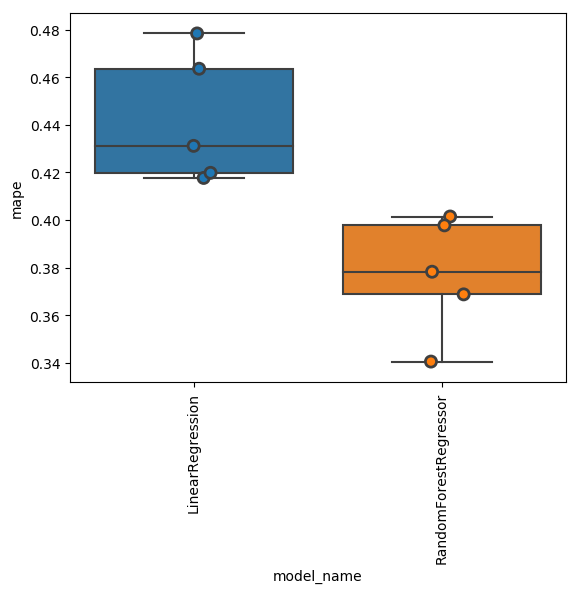

Avg LR mape = 0.4421389910253958, Avg RF mape 0.3773970643607307


Running for feature Unique_Viewers, lag 2


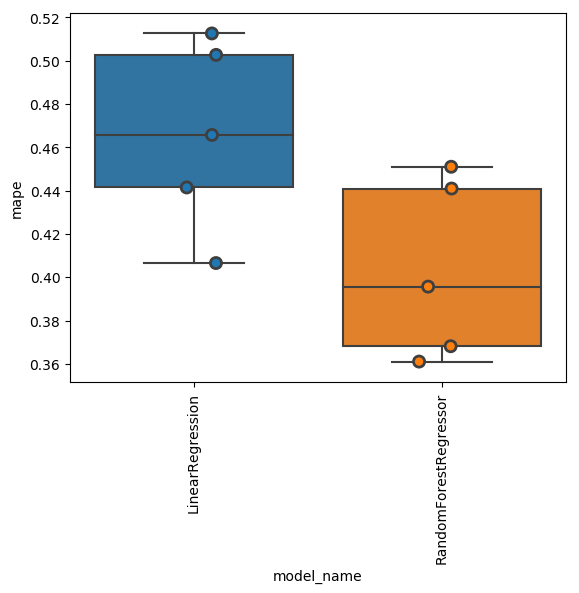

Avg LR mape = 0.4658164361883891, Avg RF mape 0.4033611102658748


Running for feature Unique_Viewers, lag 3


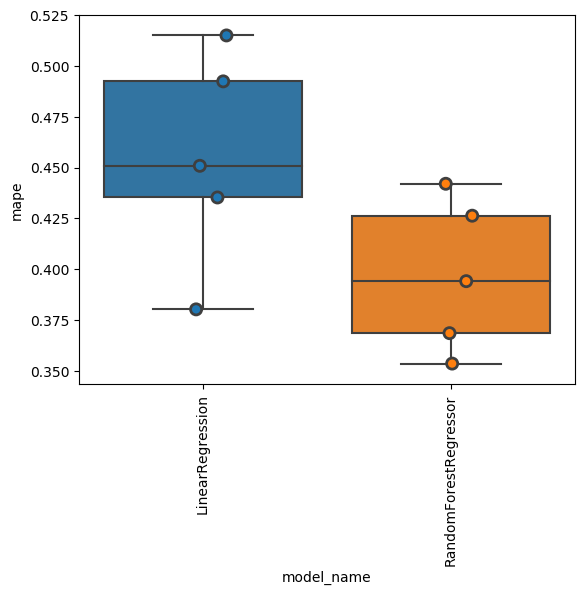

Avg LR mape = 0.4548059695594338, Avg RF mape 0.3969767992090866


Running for feature Unique_Viewers, lag 4


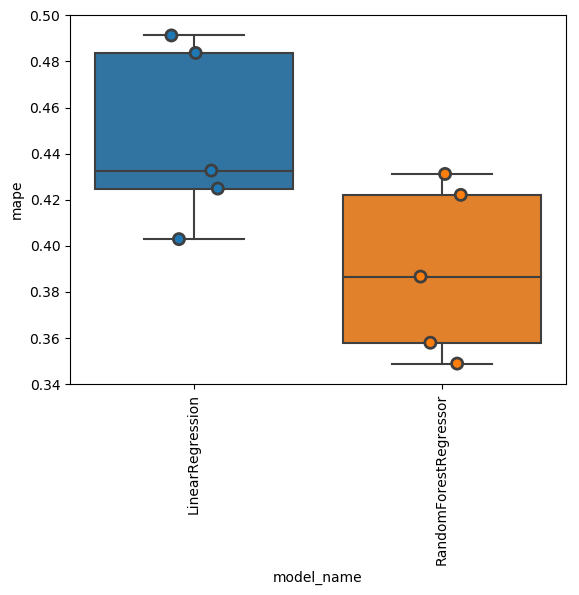

Avg LR mape = 0.44706901820336215, Avg RF mape 0.3893301474686455


Running for feature norm_minutes, lag 1


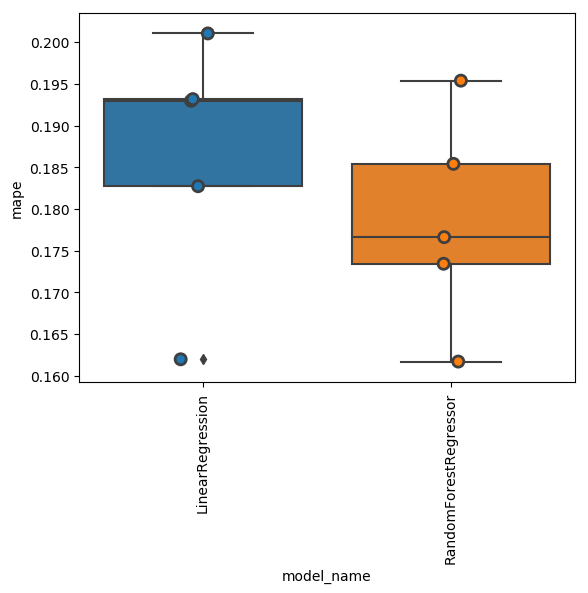

Avg LR mape = 0.18637545385540516, Avg RF mape 0.1785071907588031


Running for feature norm_minutes, lag 2


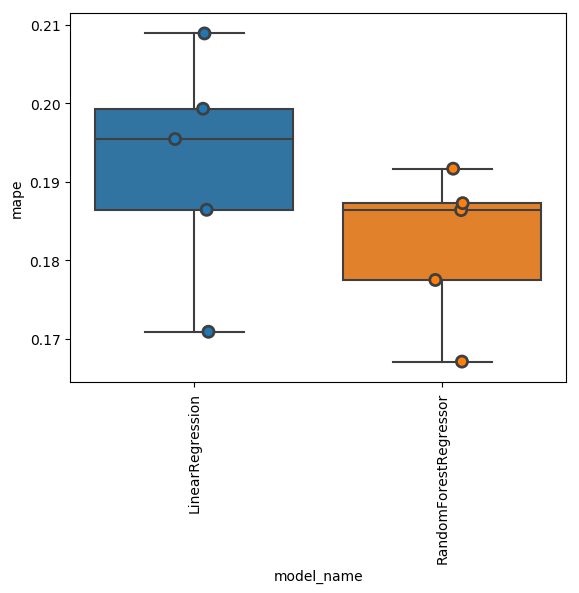

Avg LR mape = 0.19219675036209566, Avg RF mape 0.181997929345407


Running for feature norm_minutes, lag 3


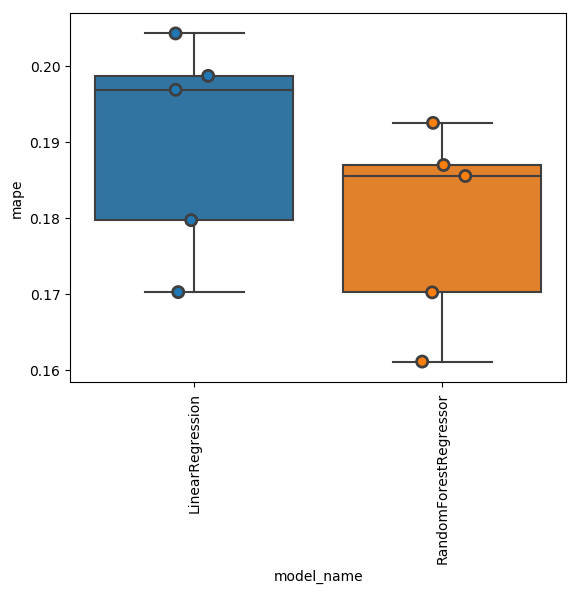

Avg LR mape = 0.18993231774954417, Avg RF mape 0.17923623687747212


Running for feature norm_minutes, lag 4


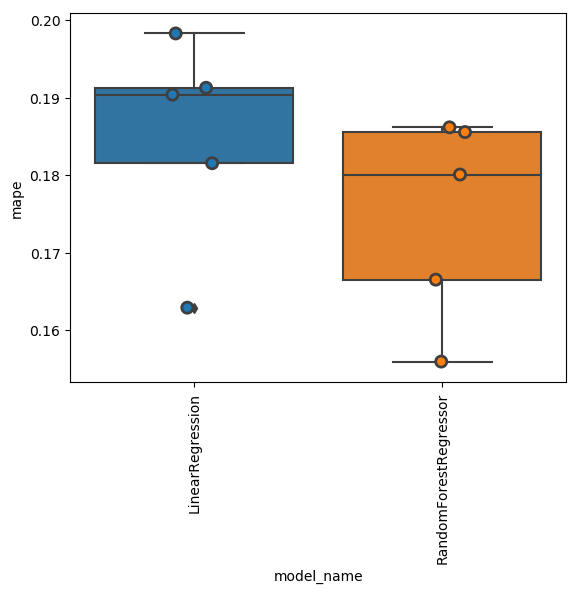

Avg LR mape = 0.18486338463148844, Avg RF mape 0.17484557304974863


Running for feature avg_markup_norm, lag 1


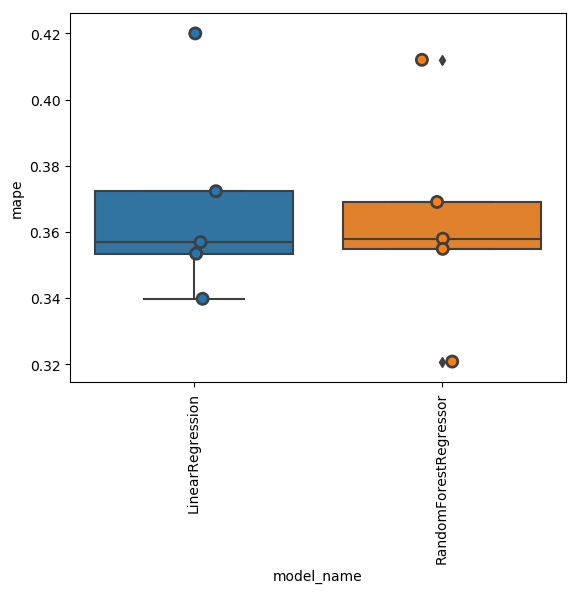

Avg LR mape = 0.36850252257399374, Avg RF mape 0.36296263667437034


Running for feature avg_markup_norm, lag 2


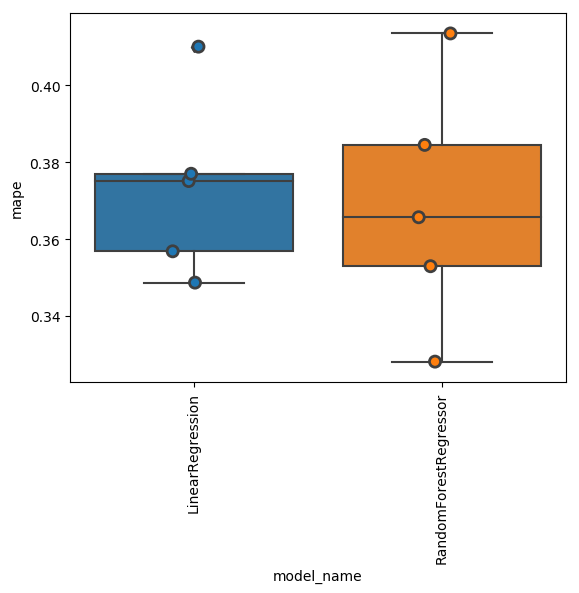

Avg LR mape = 0.37356874832676695, Avg RF mape 0.36898867158226156


Running for feature avg_markup_norm, lag 3


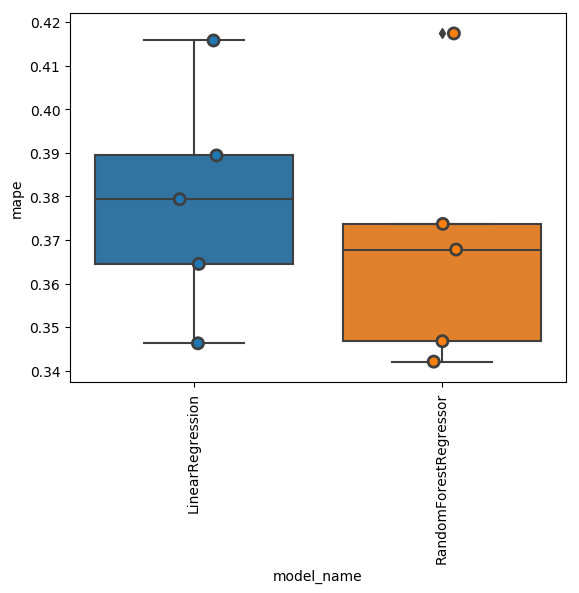

Avg LR mape = 0.3790679870407259, Avg RF mape 0.3695506539656066


Running for feature avg_markup_norm, lag 4


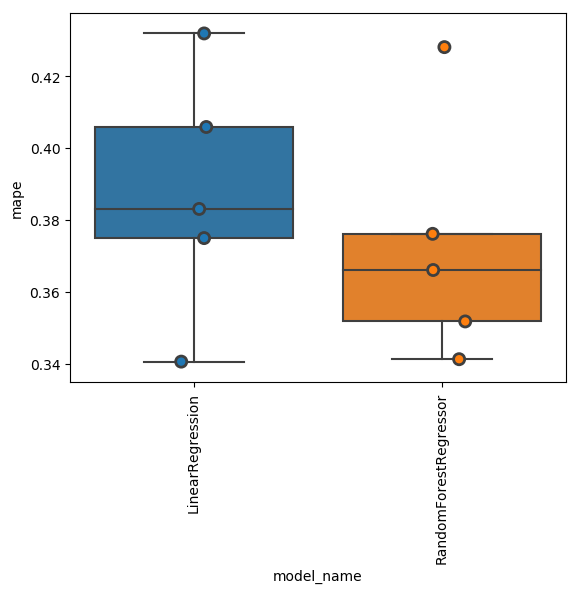

Avg LR mape = 0.3873202366866421, Avg RF mape 0.3727178215496421




In [457]:
for f in tgt_features:
    for j in range(4):
        
        print("Running for feature {0}, lag {1}".format(f, j+1))
        if j > 0:
            df = df.dropna()
        
        df_train = df.sample(frac=0.9,random_state=42)
        df_test = df.drop(df_train.index)
        
        if f == 'avg_markup_norm':
            df_train = df_train[df_train.avg_markup_norm>0]
            
        X_train = df_train[social_feats[j]]
        y_train = df_train[f]
        X_test = df_test[social_feats[j]]
        
        models = [
            LinearRegression(),
            RandomForestRegressor(max_features=14, max_depth=10, min_samples_leaf=5, n_estimators=15),
        ]

        CV = 5
        cv_df = pd.DataFrame(index=range(CV * len(models)))
        entries = []
        for model in models:
            model_name = model.__class__.__name__
            MAPEs = cross_val_score(model, X_train, y_train, scoring=scorer, cv=5)
            for fold_idx, MAPE in enumerate(MAPEs):
                entries.append((model_name, fold_idx, MAPE))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'mape'])

        sns.boxplot(x='model_name', y='mape', data=cv_df)
        vis = sns.stripplot(x='model_name', y='mape', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
        vis.set_xticklabels(vis.get_xticklabels(), rotation=90)
        plt.show()
        
        lmean = cv_df[cv_df.model_name=='LinearRegression']['mape'].mean()
        rmean = cv_df[cv_df.model_name=='RandomForestRegressor']['mape'].mean()
        
        print('Avg LR mape = {0}, Avg RF mape {1}'.format(lmean, rmean))
        print('')
        print('')
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df_test.loc[:, 'LR_pred_'+f+'_'+str(j+1)] = y_pred
        outfile = 'LR_pred_'+f+'_'+str(j+1)+'.csv'
        modelfile = 'LR_model_'+f+'_'+str(j+1)+'.pkl'
        df_test.to_csv(outfile, index=None)
        with open(modelfile, 'wb') as fd:
            pickle.dump(model, fd)
        
        model = RandomForestRegressor(max_features=14, max_depth=10, min_samples_leaf=5, n_estimators=15)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df_test.loc[:, 'RF_pred_'+f+'_'+str(j+1)] = y_pred
        outfile = 'RF_pred_'+f+'_'+str(j+1)+'.csv'
        df_test.to_csv(outfile, index=None)
        modelfile = 'RF_model_'+f+'_'+str(j+1)+'.pkl'
        with open(modelfile, 'wb') as fd:
            pickle.dump(model, fd)
        
        

In [458]:
!ls -l *.csv

-rw-rw-r-- 1 asanzgiri asanzgiri   124657 Sep 21 00:44 final_predictions.csv
-rw-rw-r-- 1 asanzgiri asanzgiri   297480 Jul  9 00:37 game_data.csv
-rw-r--r-- 1 asanzgiri asanzgiri   213364 Jun 28 20:52 game_schedule.csv
-rw-rw-r-- 1 asanzgiri asanzgiri   340038 Sep 21 12:32 LR_pred_avg_markup_norm_1.csv
-rw-rw-r-- 1 asanzgiri asanzgiri   340043 Sep 21 12:32 LR_pred_avg_markup_norm_2.csv
-rw-rw-r-- 1 asanzgiri asanzgiri   340042 Sep 21 12:32 LR_pred_avg_markup_norm_3.csv
-rw-rw-r-- 1 asanzgiri asanzgiri   340047 Sep 21 12:32 LR_pred_avg_markup_norm_4.csv
-rw-rw-r-- 1 asanzgiri asanzgiri   339982 Sep 21 12:32 LR_pred_norm_minutes_1.csv
-rw-rw-r-- 1 asanzgiri asanzgiri   339992 Sep 21 12:32 LR_pred_norm_minutes_2.csv
-rw-rw-r-- 1 asanzgiri asanzgiri   339973 Sep 21 12:32 LR_pred_norm_minutes_3.csv
-rw-rw-r-- 1 asanzgiri asanzgiri   339983 Sep 21 12:32 LR_pred_norm_minutes_4.csv
-rw-rw-r-- 1 asanzgiri asanzgiri   475691 Sep 21 12:32 LR_pred_Unique_Viewers_1.csv
-rw-rw-r-- 1 asanzgiri asanzg

In [459]:
!ls -l *.pkl

-rw-rw-r-- 1 asanzgiri asanzgiri    723 Sep 21 12:32 LR_model_avg_markup_norm_1.pkl
-rw-rw-r-- 1 asanzgiri asanzgiri    723 Sep 21 12:32 LR_model_avg_markup_norm_2.pkl
-rw-rw-r-- 1 asanzgiri asanzgiri    723 Sep 21 12:32 LR_model_avg_markup_norm_3.pkl
-rw-rw-r-- 1 asanzgiri asanzgiri    723 Sep 21 12:32 LR_model_avg_markup_norm_4.pkl
-rw-rw-r-- 1 asanzgiri asanzgiri    723 Sep 21 12:32 LR_model_norm_minutes_1.pkl
-rw-rw-r-- 1 asanzgiri asanzgiri    723 Sep 21 12:32 LR_model_norm_minutes_2.pkl
-rw-rw-r-- 1 asanzgiri asanzgiri    723 Sep 21 12:32 LR_model_norm_minutes_3.pkl
-rw-rw-r-- 1 asanzgiri asanzgiri    723 Sep 21 12:32 LR_model_norm_minutes_4.pkl
-rw-rw-r-- 1 asanzgiri asanzgiri    723 Sep 21 12:32 LR_model_Unique_Viewers_1.pkl
-rw-rw-r-- 1 asanzgiri asanzgiri    723 Sep 21 12:32 LR_model_Unique_Viewers_2.pkl
-rw-rw-r-- 1 asanzgiri asanzgiri    723 Sep 21 12:32 LR_model_Unique_Viewers_3.pkl
-rw-rw-r-- 1 asanzgiri asanzgiri    723 Sep 21 12:32 LR_model_Unique_Viewers_4.pkl
-rw-rw-r

In [460]:
with open('RF_model_norm_minutes_1.pkl', 'rb') as fid:
    best_model = pickle.load(fid)

In [560]:
with open('RF_model_norm_minutes_1.pkl', 'rb') as fid:
    best_model_norm_minutes = pickle.load(fid)
    
y_test = df_test['norm_minutes']
mape_norm_minutes = scorer(best_model_norm_minutes, X_test, y_test)
print(mape_norm_minutes)

0.21491909402060438


In [561]:
y_pred = best_model_norm_minutes.predict(X_test)
df_test.loc[:, 'pred_norm_minutes'] = y_pred

In [562]:
df_test[['Date', 'Home', 'Away', 'norm_minutes', 'pred_norm_minutes']].sample(n=5)

,Date,Home,Away,norm_minutes,pred_norm_minutes
1047,2017-03-20,ORL,PHI,20.380135,24.163983
1972,2018-01-30,DET,CLE,44.003129,33.090728
793,2017-02-09,CHA,HOU,29.100073,23.393498
2130,2018-02-26,OKC,ORL,33.257749,36.375343
1711,2017-12-23,GSW,DEN,40.884205,36.840455


In [563]:
with open('RF_model_avg_markup_norm_1.pkl', 'rb') as fid:
    best_model_avg_markup_norm = pickle.load(fid)
    
y_test = df_test['avg_markup_norm']
mape_avg_markup_norm = scorer(best_model_avg_markup_norm, X_test, y_test)
print(mape_avg_markup_norm)

0.44911117768227593


In [564]:
y_pred = best_model_avg_markup_norm.predict(X_test)
df_test.loc[:, 'pred_avg_markup_norm'] = y_pred

In [565]:
df_test[['Date', 'Home', 'Away', 'avg_markup_norm', 'pred_avg_markup_norm']].sample(n=5)

,Date,Home,Away,avg_markup_norm,pred_avg_markup_norm
1521,2017-11-27,IND,ORL,0.427,0.749382
1417,2017-11-12,DET,MIA,0.353,0.984935
835,2017-02-15,CLE,IND,0.982,1.334802
2232,2018-03-13,ATL,OKC,1.446,1.289825
1529,2017-11-28,SAC,MIL,0.512,0.822215


In [566]:
with open('RF_model_Unique_Viewers_1.pkl', 'rb') as fid:
    best_model_unique_viewers = pickle.load(fid)
    
y_test = df_test['Unique_Viewers']
mape_unique_viewers = scorer(best_model_unique_viewers, X_test, y_test)
print(mape_unique_viewers)

0.616172082083072


In [567]:
y_pred = best_model_unique_viewers.predict(X_test)
df_test.loc[:, 'pred_Unique_Viewers'] = y_pred

In [568]:
df_test[['Date', 'Home', 'Away', 'Unique_Viewers', 'pred_Unique_Viewers']].sample(n=5)

,Date,Home,Away,Unique_Viewers,pred_Unique_Viewers
2249,2018-03-15,HOU,LAC,19080.0,18943.718419
2412,2018-04-06,MEM,SAC,3799.0,6820.949208
887,2017-02-27,SAC,MIN,6844.0,11402.737997
1484,2017-11-22,HOU,DEN,7677.0,27716.646435
621,2017-01-17,CHI,DAL,23069.0,28106.041753


In [461]:
print (sorted(zip(map(lambda x: round(x, 4), best_model.feature_importances_), df_train[social_feats[0]].columns), 
             reverse=True))

[(0.495, 'inst_eng_1'), (0.0848, 'tw_eng_1'), (0.073, 'snap_foll_1'), (0.0526, 'unq_1'), (0.0433, 'fb_imps_1'), (0.0377, 'tts_1'), (0.0333, 'inst_foll_1'), (0.0301, 'fb_foll_1'), (0.03, 'wb_foll_1'), (0.0276, 'wp_1'), (0.0276, 'tw_imps_1'), (0.0235, 'gts_1'), (0.0216, 'tw_foll_1'), (0.0198, 'fb_eng_1')]


In [462]:
#!pip install eli5

In [401]:
df_train = df.sample(frac=0.9,random_state=42)
df_test = df.drop(df_train.index)
df_test[social_feats[0]].shape

(246, 14)

In [463]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(best_model, random_state=1).fit(df_test[social_feats[0]], df_test['norm_minutes'])
eli5.show_weights(perm, feature_names = df_test[social_feats[0]].columns.tolist())

Weight,Feature
0.5535 ± 0.1377,inst_eng_1
0.1165 ± 0.0546,tw_eng_1
0.0690 ± 0.0253,fb_imps_1
0.0680 ± 0.0480,unq_1
0.0457 ± 0.0328,snap_foll_1
0.0222 ± 0.0167,tts_1
0.0088 ± 0.0117,tw_imps_1
0.0075 ± 0.0159,tw_foll_1
0.0060 ± 0.0143,inst_foll_1
0.0049 ± 0.0137,fb_foll_1


In [466]:
eli_df = eli5.explain_weights_df(perm, feature_names = df_test[social_feats[0]].columns.tolist())

In [467]:
eli_df.head()

,feature,weight,std
0,inst_eng_1,0.553463,0.068871
1,tw_eng_1,0.116481,0.027305
2,fb_imps_1,0.068987,0.012634
3,unq_1,0.068025,0.024015
4,snap_foll_1,0.045733,0.016382


In [468]:
sdict2 = dict(zip(eli_df.feature.values, eli_df.weight.values))

In [469]:
sdict2

{'inst_eng_1': 0.553463295640318,
 'tw_eng_1': 0.11648142917165441,
 'fb_imps_1': 0.0689866212659305,
 'unq_1': 0.0680254009196206,
 'snap_foll_1': 0.04573300669445894,
 'tts_1': 0.02220424553560032,
 'tw_imps_1': 0.008829428087997715,
 'tw_foll_1': 0.007530075997441932,
 'inst_foll_1': 0.005983851861251344,
 'fb_foll_1': 0.004917600115662712,
 'wp_1': 0.0008828779767451556,
 'wb_foll_1': -0.002053412870250826,
 'fb_eng_1': -0.0039025222218251445,
 'gts_1': -0.007119157593281833}

In [470]:
sdict = dict(zip(df_train[social_feats[0]].columns, best_model.feature_importances_))

In [471]:
sdict

{'gts_1': 0.02351847993289823,
 'wp_1': 0.027583126053288533,
 'tts_1': 0.03769823987432099,
 'unq_1': 0.052596399349344604,
 'fb_foll_1': 0.030132055281504946,
 'inst_foll_1': 0.033297553797240725,
 'tw_foll_1': 0.02161480298194122,
 'snap_foll_1': 0.07297139301240299,
 'wb_foll_1': 0.030047330199185807,
 'fb_eng_1': 0.019783568028007435,
 'inst_eng_1': 0.49503502382328324,
 'tw_eng_1': 0.08482918139049359,
 'fb_imps_1': 0.04328309475887058,
 'tw_imps_1': 0.027609751517217222}

In [483]:
dfs = pd.read_csv('social_nba_2.csv')

In [484]:
dfs.shape

(720, 17)

In [485]:
dfs = dfs[dfs.year!=720]
dfs = dfs[dfs['Engagements_Facebook'] != ' ']

In [486]:
dfsg = dfs.copy()
dfsg['ym'] = dfsg['year'].astype(str) + dfsg['month'].astype(str)
dfsg['ym'] = pd.to_datetime(dfsg['ym'], format='%Y%m')

In [488]:
dfsg = dfsg.drop(['year', 'month'], axis=1)

In [489]:
dfsg.columns

Index(['team', 'Followers_Facebook', 'Followers_Twitter',
       'Followers_Instagram', 'Followers_Snapchat', 'Followers_Weibo',
       'Engagements_Facebook', 'Engagements_Twitter', 'Engagements_Instagram',
       'Impressions_Facebook', 'Impressions_Twitter', 'gts', 'wp_pageviews',
       'TTS', 'UNQ', 'ym'],
      dtype='object')

In [491]:
mycols = ['Followers_Facebook', 'Followers_Twitter',
       'Followers_Instagram', 'Followers_Snapchat', 'Followers_Weibo',
       'Engagements_Facebook', 'Engagements_Twitter', 'Engagements_Instagram',
       'Impressions_Facebook', 'Impressions_Twitter', 'gts', 'wp_pageviews',
       'TTS', 'UNQ']

In [492]:
from sklearn.preprocessing import *
scaler = MaxAbsScaler()
scaler.fit(dfsg[mycols])
dfsg[mycols] = scaler.transform(dfsg[mycols])

In [493]:
dfsg = dfsg.rename(columns={'Followers_Facebook': 'fb_foll_1',
                            'Followers_Twitter': 'tw_foll_1',
                            'Followers_Instagram': 'inst_foll_1',
                            'Followers_Snapchat': 'snap_foll_1',
                            'Followers_Weibo': 'wb_foll_1',
                            'Engagements_Facebook': 'fb_eng_1',
                            'Engagements_Twitter': 'tw_eng_1',
                            'Engagements_Instagram': 'inst_eng_1',
                            'Impressions_Facebook': 'fb_imps_1',
                            'Impressions_Twitter': 'tw_imps_1',
                            'gts': 'gts_1',
                            'wp_pageviews': 'wp_1',
                            'TTS': 'tts_1',
                            'UNQ': 'unq_1'})

In [494]:
mycols2 = ['fb_foll_1', 'tw_foll_1', 'inst_foll_1', 'snap_foll_1',
       'wb_foll_1', 'fb_eng_1', 'tw_eng_1', 'inst_eng_1', 'fb_imps_1',
       'tw_imps_1', 'gts_1', 'wp_1', 'tts_1', 'unq_1']

In [495]:
for col in mycols2:
    normcol = col + '_norm2'
    dfsg[normcol] = dfsg[col]*sdict2[col]

In [496]:
dfsg.columns

Index(['team', 'fb_foll_1', 'tw_foll_1', 'inst_foll_1', 'snap_foll_1',
       'wb_foll_1', 'fb_eng_1', 'tw_eng_1', 'inst_eng_1', 'fb_imps_1',
       'tw_imps_1', 'gts_1', 'wp_1', 'tts_1', 'unq_1', 'ym', 'fb_foll_1_norm2',
       'tw_foll_1_norm2', 'inst_foll_1_norm2', 'snap_foll_1_norm2',
       'wb_foll_1_norm2', 'fb_eng_1_norm2', 'tw_eng_1_norm2',
       'inst_eng_1_norm2', 'fb_imps_1_norm2', 'tw_imps_1_norm2', 'gts_1_norm2',
       'wp_1_norm2', 'tts_1_norm2', 'unq_1_norm2'],
      dtype='object')

In [497]:
dfsg['sem2']=dfsg.iloc[:,-14:].sum(axis=1)

In [498]:
dfsg['sem2']=dfsg['sem2']*100.

In [499]:
dfsg[dfsg.team=='GSW'].head()

,team,fb_foll_1,tw_foll_1,inst_foll_1,snap_foll_1,wb_foll_1,fb_eng_1,tw_eng_1,inst_eng_1,fb_imps_1,tw_imps_1,gts_1,wp_1,tts_1,unq_1,ym,fb_foll_1_norm2,tw_foll_1_norm2,inst_foll_1_norm2,snap_foll_1_norm2,wb_foll_1_norm2,fb_eng_1_norm2,tw_eng_1_norm2,inst_eng_1_norm2,fb_imps_1_norm2,tw_imps_1_norm2,gts_1_norm2,wp_1_norm2,tts_1_norm2,unq_1_norm2,sem2
9,GSW,0.421019,0.328884,0.557772,0.375777,0.558494,0.223372,0.058616,0.041549,0.278212,0.200071,0.962000,0.089178,0.422974,0.231583,2016-09-01,0.002070,0.002477,0.003338,0.017185,-0.001147,-0.000872,0.006828,0.022996,0.019193,0.001767,-0.006849,0.000079,0.009392,0.015753,9.220962
39,GSW,0.429204,0.341179,0.575483,0.390357,0.560241,0.508789,0.233937,0.137548,0.520212,0.582136,0.999677,0.152754,0.328951,0.329650,2016-10-01,0.002111,0.002569,0.003444,0.017852,-0.001150,-0.001986,0.027249,0.076128,0.035888,0.005140,-0.007117,0.000135,0.007304,0.022425,18.999074
69,GSW,0.435527,0.346662,0.583938,0.406579,0.572606,1.000000,0.424777,0.196399,0.840812,0.769106,0.960667,0.176913,0.335634,0.352612,2016-11-01,0.002142,0.002610,0.003494,0.018594,-0.001176,-0.003903,0.049479,0.108700,0.058005,0.006791,-0.006839,0.000156,0.007452,0.023987,26.949196
99,GSW,0.435527,0.346662,0.583938,0.453238,0.595370,0.783736,0.416138,0.196399,0.788669,0.699356,0.982258,0.290446,0.270934,0.296259,2016-12-01,0.002142,0.002610,0.003494,0.020728,-0.001223,-0.003059,0.048472,0.108700,0.054408,0.006175,-0.006993,0.000256,0.006016,0.020153,26.188022
129,GSW,0.465839,0.404087,0.635939,0.475810,0.618497,0.981566,0.464272,0.197943,1.000000,0.804376,0.955161,0.518083,0.398494,0.419326,2017-01-01,0.002291,0.003043,0.003805,0.021760,-0.001270,-0.003831,0.054079,0.109554,0.068987,0.007102,-0.006800,0.000457,0.008848,0.028525,29.655110


In [500]:
dfsgp = dfsg[['ym', 'team', 'sem2']]

In [503]:
dfsg.team.unique()

array(['ATL', 'BOS', 'BRK', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET',
       'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN',
       'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS',
       'TOR', 'UTA', 'WAS'], dtype=object)

In [504]:
atlantic = ['BOS', 'BRK', 'NYK', 'PHI', 'TOR']
central = ['CHI', 'CLE', 'DET', 'IND', 'MIL']
southeast = ['ATL', 'CHA', 'MIA', 'ORL', 'WAS']

southwest = ['DAL', 'HOU', 'MEM', 'NOP', 'SAS']
northwest = ['DEN', 'MIN', 'OKC', 'POR', 'UTA']
pacific = ['GSW', 'LAC', 'LAL', 'PHX', 'SAC']

eastern = atlantic + central + southeast
western = southwest + northwest + pacific

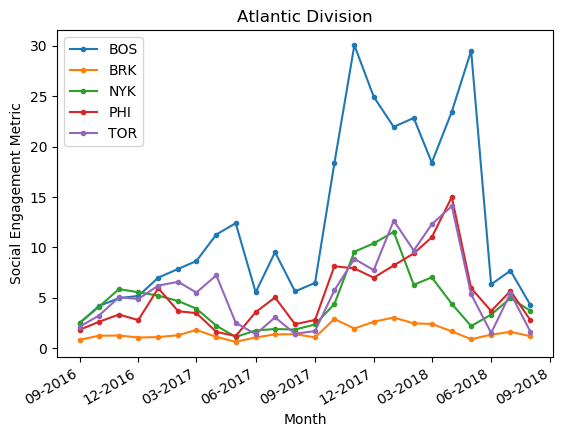

In [506]:
for i in atlantic:
    dfsgp_i = dfsgp[dfsgp.team == i]
    plt.plot(dfsgp_i['ym'], dfsgp_i['sem2'], marker='.', label=i)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.legend(loc='best')
plt.xlabel('Month')
plt.ylabel('Social Engagement Metric')
plt.title('Atlantic Division')
plt.show()

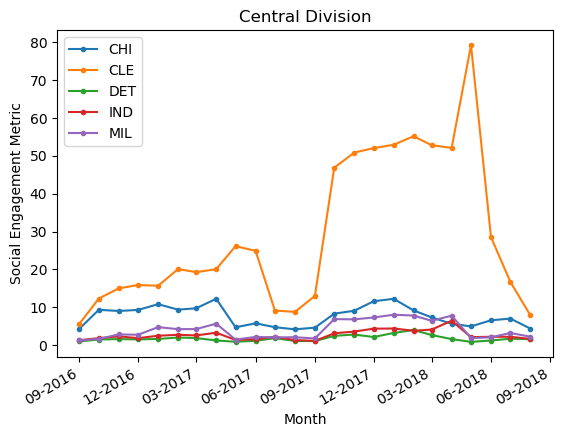

In [508]:
for i in central:
    dfsgp_i = dfsgp[dfsgp.team == i]
    plt.plot(dfsgp_i['ym'], dfsgp_i['sem2'], marker='.', label=i)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.legend(loc='best')
plt.xlabel('Month')
plt.ylabel('Social Engagement Metric')
plt.title('Central Division')
plt.show()

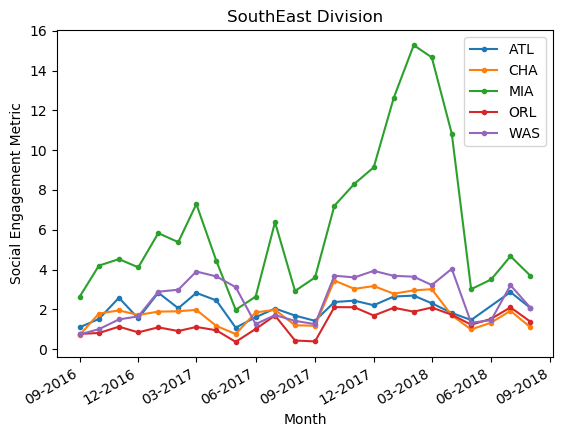

In [509]:
for i in southeast:
    dfsgp_i = dfsgp[dfsgp.team == i]
    plt.plot(dfsgp_i['ym'], dfsgp_i['sem2'], marker='.', label=i)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.legend(loc='best')
plt.xlabel('Month')
plt.ylabel('Social Engagement Metric')
plt.title('SouthEast Division')
plt.show()

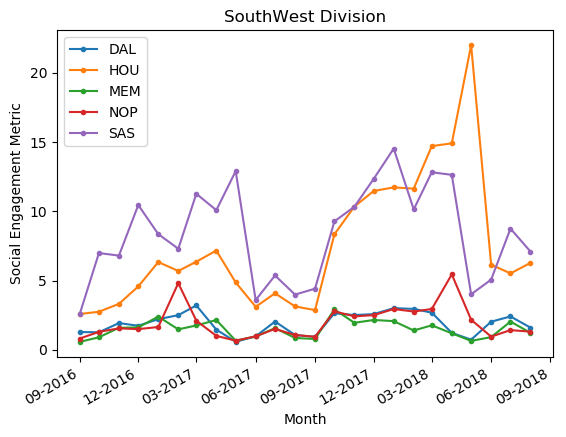

In [510]:
for i in southwest:
    dfsgp_i = dfsgp[dfsgp.team == i]
    plt.plot(dfsgp_i['ym'], dfsgp_i['sem2'], marker='.', label=i)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.legend(loc='best')
plt.xlabel('Month')
plt.ylabel('Social Engagement Metric')
plt.title('SouthWest Division')
plt.show()

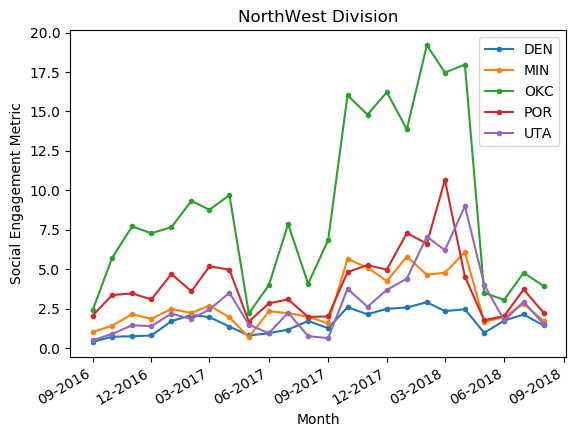

In [511]:
for i in northwest:
    dfsgp_i = dfsgp[dfsgp.team == i]
    plt.plot(dfsgp_i['ym'], dfsgp_i['sem2'], marker='.', label=i)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.legend(loc='best')
plt.xlabel('Month')
plt.ylabel('Social Engagement Metric')
plt.title('NorthWest Division')
plt.show()

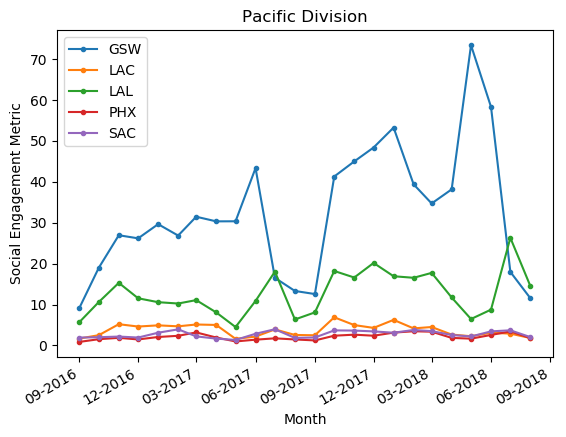

In [512]:
for i in pacific:
    dfsgp_i = dfsgp[dfsgp.team == i]
    plt.plot(dfsgp_i['ym'], dfsgp_i['sem2'], marker='.', label=i)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.legend(loc='best')
plt.xlabel('Month')
plt.ylabel('Social Engagement Metric')
plt.title('Pacific Division')
plt.show()

In [513]:
plt.rcParams['figure.figsize'] = (16,6)

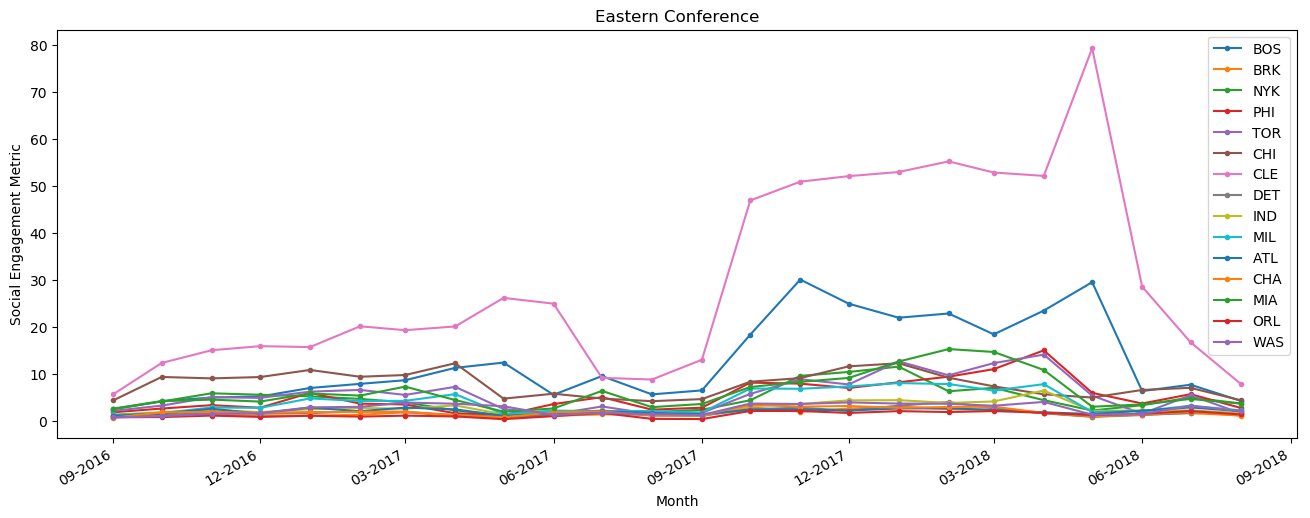

In [515]:
for i in eastern:
    dfsgp_i = dfsgp[dfsgp.team == i]
    plt.plot(dfsgp_i['ym'], dfsgp_i['sem2'], marker='.', label=i)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.legend(loc='best')
plt.xlabel('Month')
plt.ylabel('Social Engagement Metric')
plt.title('Eastern Conference')
plt.show()

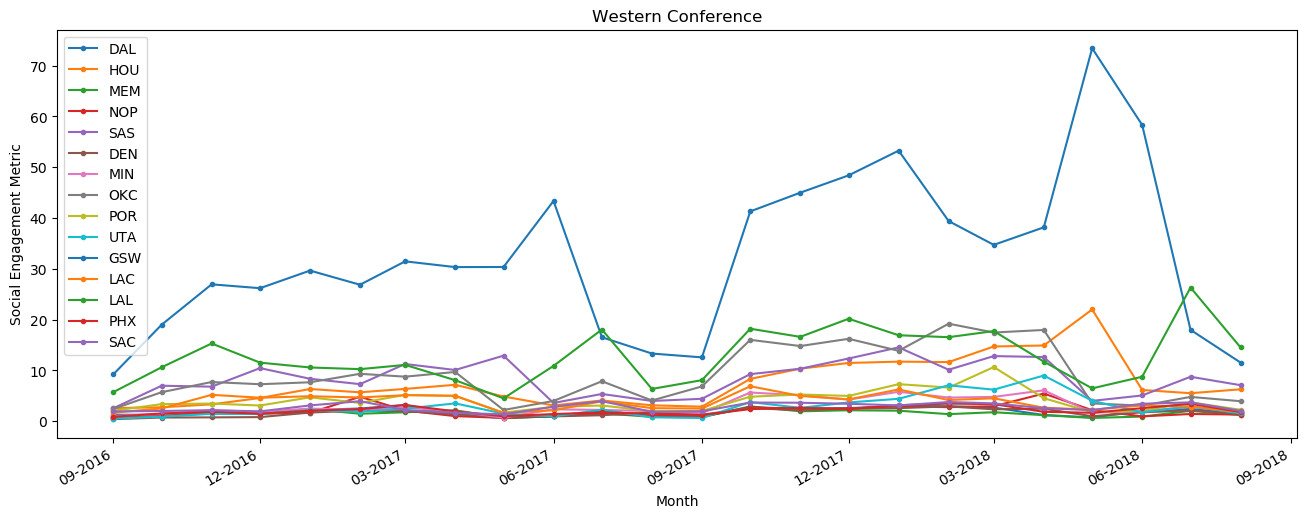

In [516]:
for i in western:
    dfsgp_i = dfsgp[dfsgp.team == i]
    plt.plot(dfsgp_i['ym'], dfsgp_i['sem2'], marker='.', label=i)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.legend(loc='best')
plt.xlabel('Month')
plt.ylabel('Social Engagement Metric')
plt.title('Western Conference')
plt.show()

In [517]:
dff = dfsgp[dfsgp.ym=='2018-08-01']

In [518]:
dff['social_score']= dff['sem2']

/home/asanzgiri/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [519]:
dff[['team','social_score']].sort_values(by='social_score', ascending=False)

,team,social_score
703,LAL,14.530181
699,GSW,11.551619
695,CLE,7.904680
716,SAS,7.097502
700,HOU,6.281567
694,CHI,4.392068
691,BOS,4.278005
710,OKC,3.942186
709,NYK,3.714027
705,MIA,3.685984


In [528]:
df2 = pd.read_csv('nba_final_datatset.csv')
df2.shape

(2459, 136)

In [529]:
df2  = df2[df2.point_spread > 0]

In [530]:
len(df2.point_spread.values)

2296

In [531]:
j = '1'
df2['gts_'+j] = df2['Home_gts_'+j] + df2['Away_gts_'+j]
df2['wp_'+j] = df2['Home_wp_pageviews_'+j] + df2['Away_wp_pageviews_'+j]
df2['tts_'+j] = df2['Home_TTS_'+j] + df2['Away_TTS_'+j]
df2['unq_'+j] = df2['Home_UNQ_'+j] + df2['Away_UNQ_'+j]

df2['fb_foll_'+j] = df2['Home_Followers_Facebook_'+j] + df2['Away_Followers_Facebook_'+j]
df2['inst_foll_'+j] = df2['Home_Followers_Instagram_'+j] + df2['Away_Followers_Instagram_'+j]
df2['tw_foll_'+j] = df2['Home_Followers_Twitter_'+j] + df2['Away_Followers_Twitter_'+j]
df2['snap_foll_'+j] = df2['Home_Followers_Snapchat_'+j] + df2['Away_Followers_Snapchat_'+j]
df2['wb_foll_'+j] = df2['Home_Followers_Weibo_'+j] + df2['Away_Followers_Weibo_'+j]

df2['fb_eng_'+j] = df2['Home_Engagements_Facebook_'+j] + df2['Away_Engagements_Facebook_'+j]
df2['inst_eng_'+j] = df2['Home_Engagements_Instagram_'+j] + df2['Away_Engagements_Instagram_'+j]
df2['tw_eng_'+j] = df2['Home_Engagements_Twitter_'+j] + df2['Away_Engagements_Twitter_'+j]

df2['fb_imps_'+j] = df2['Home_Impressions_Facebook_'+j] + df2['Away_Impressions_Facebook_'+j]
df2['tw_imps_'+j] = df2['Home_Impressions_Twitter_'+j] + df2['Away_Impressions_Twitter_'+j]
    
social_feats = ['gts_'+j, 'wp_'+j, 'tts_'+j, 'unq_'+j,
                'fb_foll_'+j, 'inst_foll_'+j, 'tw_foll_'+j, 'snap_foll_'+j, 'wb_foll_'+j, 
                'fb_eng_'+j, 'inst_eng_'+j, 'tw_eng_'+j, 'fb_imps_'+j, 'tw_imps_'+j]
    
scaler = MaxAbsScaler()
scaler.fit(df2[social_feats])
df2[social_feats] = scaler.transform(df2[social_feats])

In [532]:
for col in social_feats:
    normcol = col + '_norm'
    df2[normcol] = df2[col]*sdict[col]

In [533]:
df2['sem'] = df2.iloc[:,-14:].sum(axis=1)
df2['sem'] = df2['sem']*100.

In [534]:
df2['sem'].describe()

count    2296.000000
mean       16.797615
std        11.878416
min         3.087864
25%         8.812452
50%        13.261099
75%        20.010780
max        88.726051
Name: sem, dtype: float64

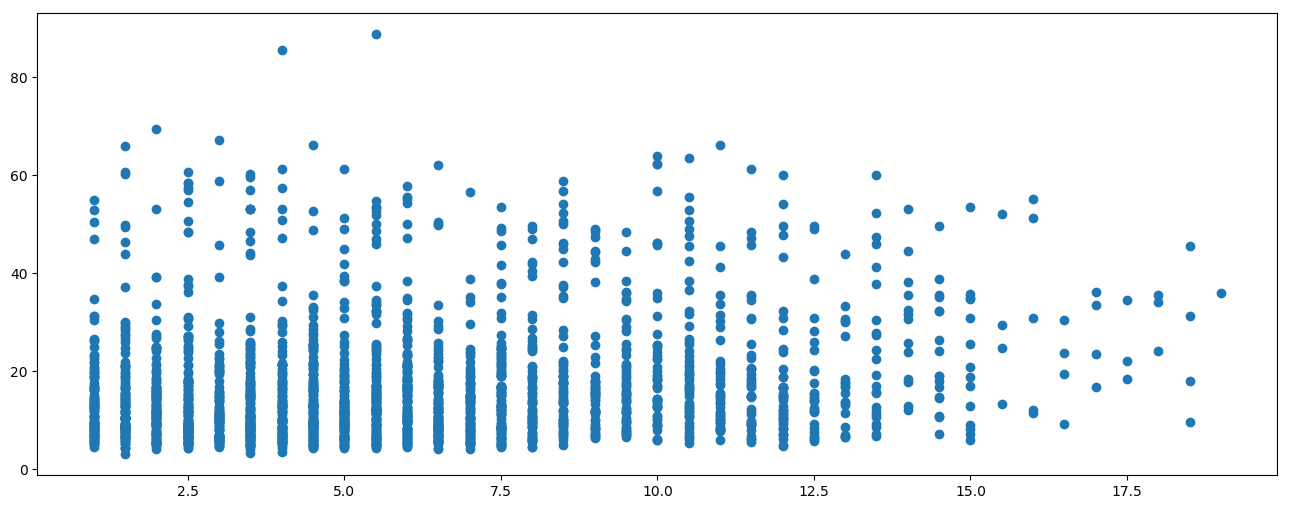

In [535]:
plt.scatter(df2.point_spread, df2['sem'])
plt.show()

In [536]:
df2['point_spread'].value_counts()

2.5     149
3.5     143
4.5     140
5.5     131
6.0     127
2.0     123
5.0     120
1.5     118
6.5     116
4.0     113
7.5     110
1.0     104
3.0      98
7.0      81
8.0      72
8.5      67
9.5      56
9.0      55
10.5     52
10.0     51
11.0     44
12.0     43
11.5     40
12.5     27
13.5     23
13.0     21
14.5     17
15.0     14
14.0     13
16.0      5
18.5      4
17.0      4
15.5      4
16.5      4
18.0      3
17.5      3
19.0      1
Name: point_spread, dtype: int64

In [537]:
df2[df2.point_spread==1.0]['sem'].describe()

count    104.000000
mean      14.876268
std        9.890963
min        4.531070
25%        8.245179
50%       12.548783
75%       18.714289
max       54.927994
Name: sem, dtype: float64

In [538]:
df2.to_csv('point_spread_data2.csv', index=None)

In [570]:
dfsgp.to_csv('nba_stock_index.csv', index=None)